This notebook serves as a playground for experimenting with data science using Python and Spotify APIs

First we install a few necessary libraries

In [2]:
!pip install -q numpy
!pip install -q pandas
!pip install requests

Next, we are using a spotify API client made using a tutorial found here: [video](https://www.youtube.com/watch?v=xdq6Gz33khQ) [GitHub](https://github.com/codingforentrepreneurs/30-Days-of-Python/blob/master/tutorial-reference/Day%2019/notebooks/spotify_client.py)

In [3]:
import base64
import datetime
from urllib.parse import urlencode

import requests

#Uses Spotiy's "Client Credentials Flow"
class SpotifyAPI(object):
    access_token = None
    access_token_expires = datetime.datetime.now()
    access_token_did_expire = True
    client_id = None
    client_secret = None
    token_url = "https://accounts.spotify.com/api/token"
    
    #external functions ("public")
    

    def __init__(self, client_id, client_secret, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.client_id = client_id
        self.client_secret = client_secret

    def get_album(self, _id):
        return self.get_resource(_id, resource_type='albums')
    
    def get_artist(self, _id):
        return self.get_resource(_id, resource_type='artists')

    def get_playlist(self, _id):
        return self.get_resource(_id, resource_type='playlists')

    def get_playlist_tracks(self, _id):
        return self.get_resource(_id, resource_type='playlists', addendum='tracks')

    def get_track_features(self, _id):
        return self.get_resource(_id, resource_type='audio-features')

    def get_track_analysis(self, _id):
      return self.get_resource(_id, resource_type='audio-analysis') 

    def search(self, query=None, operator=None, operator_query=None, search_type='artist', limit=20 ):
        if query == None:
            raise Exception("A query is required")
        if isinstance(query, dict):
            query = " ".join([f"{k}:{v}" for k,v in query.items()])
        if operator != None and operator_query != None:
            if operator.lower() == "or" or operator.lower() == "not":
                operator = operator.upper()
                if isinstance(operator_query, str):
                    query = f"{query} {operator} {operator_query}"
        query_params = urlencode({"q": query, "type": search_type.lower(), "limit": str(limit)})
        return self.base_search(query_params)


    #internal functions ("private")


    def get_client_credentials(self):
        """
        Returns a base64 encoded string
        """
        client_id = self.client_id
        client_secret = self.client_secret
        if client_secret == None or client_id == None:
            raise Exception("You must set client_id and client_secret")
        client_creds = f"{client_id}:{client_secret}"
        client_creds_b64 = base64.b64encode(client_creds.encode())
        return client_creds_b64.decode()
    
    def get_token_headers(self):
        client_creds_b64 = self.get_client_credentials()
        return {
            "Authorization": f"Basic {client_creds_b64}"
        }
    
    def get_token_data(self):
        return {
            "grant_type": "client_credentials"
        } 
    
    def perform_auth(self):
        token_url = self.token_url
        token_data = self.get_token_data()
        token_headers = self.get_token_headers()
        r = requests.post(token_url, data=token_data, headers=token_headers)
        if r.status_code not in range(200, 299):
            raise Exception("Could not authenticate client.")
            # return False
        data = r.json()
        now = datetime.datetime.now()
        access_token = data['access_token']
        expires_in = data['expires_in'] # seconds
        expires = now + datetime.timedelta(seconds=expires_in)
        self.access_token = access_token
        self.access_token_expires = expires
        self.access_token_did_expire = expires < now
        return True
    
    def get_access_token(self):
        token = self.access_token
        expires = self.access_token_expires
        now = datetime.datetime.now()
        if expires < now:
            self.perform_auth()
            return self.get_access_token()
        elif token == None:
            self.perform_auth()
            return self.get_access_token() 
        return token
    
    def get_resource_header(self):
        access_token = self.get_access_token()
        headers = {
            "Authorization": f"Bearer {access_token}"
        }
        return headers
        
        
    def get_resource(self, lookup_id, resource_type='albums', version='v1', addendum=''):
        endpoint = f"https://api.spotify.com/{version}/{resource_type}/{lookup_id}/{addendum}"
        headers = self.get_resource_header()
        r = requests.get(endpoint, headers=headers)
        if r.status_code not in range(200, 299):
            return {}
        return r.json()
    
    
    
    def base_search(self, query_params): # type
        headers = self.get_resource_header()
        endpoint = "https://api.spotify.com/v1/search"
        lookup_url = f"{endpoint}?{query_params}"
        r = requests.get(lookup_url, headers=headers)
        if r.status_code not in range(200, 299):  
            return {}
        return r.json()
    


Let's not forget to import the all powerful datascience libraries: NumPy and pandas !

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

Now, we pass our client ID and client secret from our Spotify Dev project into an instance of the spotify_client class. Paste in your own within the quotes. To get a your Spotify credentials, visit [here](https://developer.spotify.com/dashboard/login)

In [5]:
client_id = ""
client_secret = ""

spotify = SpotifyAPI(client_id, client_secret)

In [6]:
spotify.perform_auth()

True

To access the spotify API, we now call spotify.func()
Let's try a simple search for an artist (feel free to change the artist variable to anyone you'd like)

In [7]:
artist = "Calvin Harris"
artist_result_raw = spotify.search(query=artist) 
# the raw json we get back is formatted funny, so we have to dig to get what we want
artists_list = artist_result_raw['artists']['items'] # returns a list of the (max 20) artists that matched the term
top_artist = artists_list[0] # skims the top artist from the list

#cleaning up the artist data to only include that which is relevant
top_artist['followers'] = top_artist['followers']['total']
top_artist.pop('external_urls')
top_artist.pop('href');
top_artist.pop('images');
top_artist.pop('type');
top_artist.pop('uri');
#provides some basic artist profile information
for key, val in top_artist.items():
  print(f"{key}:{val}")




followers:21870550
genres:['dance pop', 'edm', 'electro house', 'house', 'pop', 'progressive house', 'uk dance']
id:7CajNmpbOovFoOoasH2HaY
name:Calvin Harris
popularity:89


Let's try using pandas dataframes to display a list of data. Let's see if we can find some similarities between tracks with generic words in their name. Change the word variable to some generic word (fx: "love", "magic", "beautiful')

In [8]:
word = "sun"
tracks_results_raw = spotify.search(query=word, search_type='track', limit=50)
all_tracks = tracks_results_raw['tracks']['items']

for track in all_tracks:
  track['album'] = track['album']['name']
  artists = []
  for artist in track['artists']:
    artists.append(artist['name'])
  track['artists'] = artists
  track.pop('available_markets')
  track.pop('disc_number')
  track.pop('external_ids')
  track.pop('external_urls')
  track.pop('href')
  track.pop('is_local')
  track.pop('preview_url')
  track.pop('track_number')
  track.pop('type')
  track.pop('uri')


tracks_dataframe = pd.DataFrame(all_tracks)
tracks_dataframe



,album,artists,duration_ms,explicit,id,name,popularity
0,Spider-Man: Into the Spider-Verse (Soundtrack ...,"[Post Malone, Swae Lee]",158040,False,3KkXRkHbMCARz0aVfEt68P,Sunflower - Spider-Man: Into the Spider-Verse,82
1,Where the Light Is,[Surfaces],158571,False,1Cv1YLb4q0RzL6pybtaMLo,Sunday Best,80
2,SUN GOES DOWN,[Lil Nas X],168275,False,34eF4BoV8FPk0uhAAoqU7h,SUN GOES DOWN,81
3,Sunflower,[Rex Orange County],252230,True,4EpZ4eYuZOwPSSwyqpdHnJ,Sunflower,77
4,Sundress,[A$AP Rocky],158205,True,2aPTvyE09vUCRwVvj0I8WK,Sundress,77
5,Weezer (Green Album),[Weezer],200306,False,2MLHyLy5z5l5YRp7momlgw,Island In The Sun,78
6,Abbey Road (Remastered),[The Beatles],185733,False,6dGnYIeXmHdcikdzNNDMm2,Here Comes The Sun - Remastered 2009,82
7,Surf,[Donnie Trumpet & The Social Experiment],226013,False,6fTdcGsjxlAD9PSkoPaLMX,Sunday Candy,64
8,Now and Then,[khai dreams],126464,False,1tD8J13a74q8fBqXwAP50j,Sunkissed,73
9,Songs About Jane: 10th Anniversary Edition,[Maroon 5],244880,False,5qII2n90lVdPDcgXEEVHNy,Sunday Morning,70


How cool! We now see spotify's top 50 tracks for a search term. But wouldn't it be cooler if we could get even more data on tracks than what is seen here? Well, we can do that! Spotify has another api call that gives more detailed information on their tracks.

In [9]:
all_tracks_features = []

for track in all_tracks:
  all_tracks_features.append(spotify.get_track_features(track['id']))

for feature in all_tracks_features:
  feature.pop('analysis_url')
  feature.pop('duration_ms')
  feature.pop('id')
  feature.pop('track_href')
  feature.pop('type')
  feature.pop('uri')
features_dataframe = pd.DataFrame(all_tracks_features)
features_dataframe.head()


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,0.760,0.479,2,-5.574,1,0.0466,0.5560,0.000000,0.0703,0.913,89.911,4
1,0.878,0.525,5,-6.832,1,0.0578,0.1830,0.000000,0.0714,0.694,112.022,4
2,0.551,0.636,2,-6.798,1,0.0540,0.0837,0.000004,0.1120,0.148,174.065,4
3,0.384,0.765,6,-4.463,1,0.0579,0.6460,0.003520,0.5220,0.567,129.903,4
4,0.721,0.707,6,-6.364,1,0.0595,0.1810,0.000004,0.1430,0.743,125.005,4


And now, we combine the dataframes into a single, data packed dataframe!

In [10]:
tracks_dataframe_complete = pd.concat([tracks_dataframe, features_dataframe], axis=1, sort=False)
tracks_dataframe_numeric = tracks_dataframe_complete.drop(columns=['album', 'explicit', 'artists','id','name', 'time_signature'])
tracks_dataframe_complete.head()

,album,artists,duration_ms,explicit,id,name,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,Spider-Man: Into the Spider-Verse (Soundtrack ...,"[Post Malone, Swae Lee]",158040,False,3KkXRkHbMCARz0aVfEt68P,Sunflower - Spider-Man: Into the Spider-Verse,82,0.760,0.479,2,-5.574,1,0.0466,0.5560,0.000000,0.0703,0.913,89.911,4
1,Where the Light Is,[Surfaces],158571,False,1Cv1YLb4q0RzL6pybtaMLo,Sunday Best,80,0.878,0.525,5,-6.832,1,0.0578,0.1830,0.000000,0.0714,0.694,112.022,4
2,SUN GOES DOWN,[Lil Nas X],168275,False,34eF4BoV8FPk0uhAAoqU7h,SUN GOES DOWN,81,0.551,0.636,2,-6.798,1,0.0540,0.0837,0.000004,0.1120,0.148,174.065,4
3,Sunflower,[Rex Orange County],252230,True,4EpZ4eYuZOwPSSwyqpdHnJ,Sunflower,77,0.384,0.765,6,-4.463,1,0.0579,0.6460,0.003520,0.5220,0.567,129.903,4
4,Sundress,[A$AP Rocky],158205,True,2aPTvyE09vUCRwVvj0I8WK,Sundress,77,0.721,0.707,6,-6.364,1,0.0595,0.1810,0.000004,0.1430,0.743,125.005,4


Now that we have some data built, let's visualize it!

In [11]:
tracks_dataframe_numeric.describe()

,duration_ms,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,50.000000,50.000000,50.000000,50.00000,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.00000,50.000000,50.000000
mean,200848.820000,67.320000,0.639720,0.61054,5.22000,-7.649340,0.660000,0.075272,0.286103,0.097205,0.15177,0.543120,120.097480
std,48233.150184,15.934099,0.164947,0.18644,3.59302,3.269316,0.478518,0.071540,0.275855,0.242545,0.10549,0.249577,24.816505
min,88644.000000,0.000000,0.292000,0.10600,0.00000,-18.859000,0.000000,0.026200,0.000217,0.000000,0.04560,0.112000,75.302000
25%,167395.250000,63.250000,0.536000,0.47950,2.00000,-9.463000,0.000000,0.035225,0.078300,0.000000,0.08845,0.330500,101.355000
50%,200346.000000,70.000000,0.650500,0.60250,5.50000,-6.745000,1.000000,0.050500,0.187500,0.000006,0.11250,0.575500,120.932500
75%,229142.500000,77.000000,0.770500,0.75800,9.00000,-5.579000,1.000000,0.090725,0.504250,0.002059,0.17550,0.741250,129.967500
max,320573.000000,84.000000,0.927000,0.95200,11.00000,-2.270000,1.000000,0.369000,0.934000,0.921000,0.52200,0.944000,174.065000


Lets plot the distribution of each attribute for our given word.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

(0.0, 1.0)

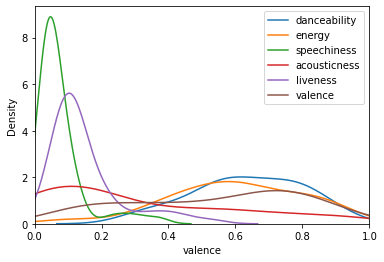

In [12]:
sns.distplot(tracks_dataframe_complete['danceability'], bins =10, hist=False, label="danceability")
sns.distplot(tracks_dataframe_complete['energy'], bins =10, hist=False, label="energy")
sns.distplot(tracks_dataframe_complete['speechiness'], bins =10, hist=False, label="speechiness")
sns.distplot(tracks_dataframe_complete['acousticness'], bins =10, hist=False, label="acousticness")
sns.distplot(tracks_dataframe_complete['liveness'], bins =10, hist=False, label="liveness")
sns.distplot(tracks_dataframe_complete['valence'], bins =10, hist=False, label="valence")
plt.legend()
plt.xlim(left=0.0, right=1.0)
#sns.distplot(tracks_dataframe_complete['instrumentalness'], bins =10, hist=False, label="instrumentalness")

Now, let's see how correlated each of these attributes are for this data set.

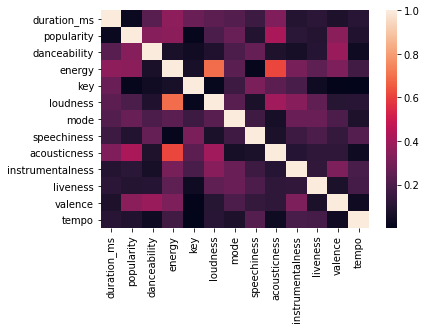

In [12]:
correlation_matrix = tracks_dataframe_numeric.corr()
sns.heatmap(correlation_matrix.abs())

Let's do this all again, but for for the Global Top 50 (if you'd rather do the US top 50, just uncomment the US top 50 line)

In [13]:
playlist_id = '37i9dQZEVXbMDoHDwVN2tF' #global top 50
#playlist_id ='37i9dQZEVXbLRQDuF5jeBp' #US top 50
top_50_raw = spotify.get_playlist_tracks(playlist_id)
type(top_50_raw)
top_50_rare = top_50_raw['items']

top_50_tracks = []
for track in top_50_rare:
  top_50_tracks.append(track['track'])

top_50_tracks[0]

for track in top_50_tracks:
  track['album'] = track['album']['name']
  artists = []
  for artist in track['artists']:
    artists.append(artist['name'])
  track['artists'] = artists
  track.pop('available_markets')
  track.pop('disc_number')
  track.pop('external_ids')
  track.pop('external_urls')
  track.pop('href')
  track.pop('is_local')
  track.pop('preview_url')
  track.pop('track_number')
  track.pop('type')
  track.pop('uri')


top_50_dataframe = pd.DataFrame(top_50_tracks)
top_50_dataframe.head()


,album,artists,duration_ms,episode,explicit,id,name,popularity,track
0,Chosen,[Måneskin],211560,False,False,3Wrjm47oTz2sjIgck11l5e,Beggin',99,True
1,F*CK LOVE 3: OVER YOU,"[The Kid LAROI, Justin Bieber]",141805,False,True,5PjdY0CKGZdEuoNab3yDmX,Stay (with Justin Bieber),37,True
2,SOUR,[Olivia Rodrigo],178146,False,True,4ZtFanR9U6ndgddUvNcjcG,good 4 u,100,True
3,Bad Habits,[Ed Sheeran],231041,False,False,6PQ88X9TkUIAUIZJHW2upE,Bad Habits,97,True
4,MONTERO (Call Me By Your Name),[Lil Nas X],137875,False,True,67BtfxlNbhBmCDR2L2l8qd,MONTERO (Call Me By Your Name),98,True


In [14]:
top_50_features = []

for track in top_50_tracks:
  top_50_features.append(spotify.get_track_features(track['id']))

for feature in top_50_features:
  feature.pop('analysis_url')
  feature.pop('duration_ms')
  feature.pop('id')
  feature.pop('track_href')
  feature.pop('type')
  feature.pop('uri')
top_50_features_dataframe = pd.DataFrame(top_50_features)
top_50_features_dataframe.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,0.714,0.800,11,-4.808,0,0.0504,0.1270,0.000000,0.3590,0.589,134.002,4
1,0.591,0.764,1,-5.484,1,0.0483,0.0383,0.000000,0.1030,0.478,169.928,4
2,0.563,0.664,9,-5.044,1,0.1540,0.3350,0.000000,0.0849,0.688,166.928,4
3,0.808,0.897,11,-3.712,0,0.0348,0.0469,0.000031,0.3640,0.591,126.026,4
4,0.610,0.508,8,-6.682,0,0.1520,0.2970,0.000000,0.3840,0.758,178.818,4


In [15]:
top_50_dataframe_complete = pd.concat([top_50_dataframe, top_50_features_dataframe], axis=1, sort=False)
top_50_dataframe_numeric = top_50_dataframe_complete.drop(columns=['album', 'explicit', 'artists','id','name', 'time_signature', 'episode', 'track'])
top_50_dataframe_complete

,album,artists,duration_ms,episode,explicit,id,name,popularity,track,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,Chosen,[Måneskin],211560,False,False,3Wrjm47oTz2sjIgck11l5e,Beggin',99,True,0.714,0.800,11,-4.808,0,0.0504,0.12700,0.000000,0.3590,0.5890,134.002,4
1,F*CK LOVE 3: OVER YOU,"[The Kid LAROI, Justin Bieber]",141805,False,True,5PjdY0CKGZdEuoNab3yDmX,Stay (with Justin Bieber),37,True,0.591,0.764,1,-5.484,1,0.0483,0.03830,0.000000,0.1030,0.4780,169.928,4
2,SOUR,[Olivia Rodrigo],178146,False,True,4ZtFanR9U6ndgddUvNcjcG,good 4 u,100,True,0.563,0.664,9,-5.044,1,0.1540,0.33500,0.000000,0.0849,0.6880,166.928,4
3,Bad Habits,[Ed Sheeran],231041,False,False,6PQ88X9TkUIAUIZJHW2upE,Bad Habits,97,True,0.808,0.897,11,-3.712,0,0.0348,0.04690,0.000031,0.3640,0.5910,126.026,4
4,MONTERO (Call Me By Your Name),[Lil Nas X],137875,False,True,67BtfxlNbhBmCDR2L2l8qd,MONTERO (Call Me By Your Name),98,True,0.610,0.508,8,-6.682,0,0.1520,0.29700,0.000000,0.3840,0.7580,178.818,4
5,Planet Her,"[Doja Cat, SZA]",208666,False,True,3DarAbFujv6eYNliUTyqtz,Kiss Me More (feat. SZA),85,True,0.764,0.705,8,-3.463,1,0.0284,0.25900,0.000089,0.1200,0.7810,110.970,4
6,INDUSTRY BABY (feat. Jack Harlow),"[Lil Nas X, Jack Harlow]",212000,False,True,27NovPIUIRrOZoCHxABJwK,INDUSTRY BABY (feat. Jack Harlow),47,True,0.736,0.704,3,-7.409,0,0.0615,0.02030,0.000000,0.0501,0.8940,149.995,4
7,VICE VERSA,[Rauw Alejandro],199604,False,True,5RwV8BvLfX5injfqYodke9,Todo De Ti,84,True,0.780,0.719,3,-3.613,0,0.0506,0.30200,0.000196,0.0931,0.3360,127.962,4
8,Yonaguni,[Bad Bunny],206710,False,True,2JPLbjOn0wPCngEot2STUS,Yonaguni,97,True,0.644,0.648,1,-4.601,1,0.1180,0.27600,0.000000,0.1350,0.4400,179.951,4
9,Teatro d'ira - Vol. I,[Måneskin],173346,False,True,4pt5fDVTg5GhEvEtlz9dKk,I WANNA BE YOUR SLAVE,96,True,0.750,0.608,1,-4.008,1,0.0387,0.00165,0.000000,0.1780,0.9580,132.507,4


In [16]:
top_50_dataframe_numeric.head()

,duration_ms,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,211560,99,0.714,0.800,11,-4.808,0,0.0504,0.1270,0.000000,0.3590,0.589,134.002
1,141805,37,0.591,0.764,1,-5.484,1,0.0483,0.0383,0.000000,0.1030,0.478,169.928
2,178146,100,0.563,0.664,9,-5.044,1,0.1540,0.3350,0.000000,0.0849,0.688,166.928
3,231041,97,0.808,0.897,11,-3.712,0,0.0348,0.0469,0.000031,0.3640,0.591,126.026
4,137875,98,0.610,0.508,8,-6.682,0,0.1520,0.2970,0.000000,0.3840,0.758,178.818


In [17]:
top_50_dataframe_numeric.describe()

,duration_ms,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,203122.520000,84.500000,0.694400,0.653140,5.040000,-5.802980,0.620000,0.092014,0.225947,0.011272,0.163206,0.553338,126.573320
std,47811.414293,18.559612,0.125811,0.141763,3.452062,1.893479,0.490314,0.061132,0.222377,0.076492,0.109828,0.226637,29.756443
min,132780.000000,0.000000,0.369000,0.272000,0.000000,-10.497000,0.000000,0.028400,0.001460,0.000000,0.044200,0.084900,80.015000
25%,173509.500000,84.250000,0.631250,0.573500,2.000000,-6.891250,0.000000,0.047550,0.040450,0.000000,0.092625,0.436250,102.220250
50%,198567.000000,90.000000,0.723000,0.659500,5.500000,-5.258500,1.000000,0.071000,0.164000,0.000000,0.113000,0.589500,124.518000
75%,214629.500000,93.000000,0.786750,0.764750,8.000000,-4.438000,1.000000,0.117500,0.327000,0.000013,0.176750,0.732500,149.518250
max,393280.000000,100.000000,0.891000,0.897000,11.000000,-3.167000,1.000000,0.319000,0.866000,0.541000,0.420000,0.958000,180.917000


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

(0.0, 1.0)

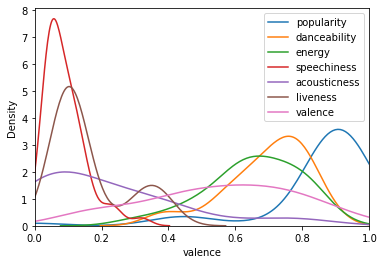

In [19]:
sns.distplot(top_50_dataframe_complete['popularity']/100, bins =10, hist=False, label="popularity")
sns.distplot(top_50_dataframe_complete['danceability'], bins =10, hist=False, label="danceability")
sns.distplot(top_50_dataframe_complete['energy'], bins =10, hist=False, label="energy")
sns.distplot(top_50_dataframe_complete['speechiness'], bins =10, hist=False, label="speechiness")
sns.distplot(top_50_dataframe_complete['acousticness'], bins =10, hist=False, label="acousticness")
sns.distplot(top_50_dataframe_complete['liveness'], bins =10, hist=False, label="liveness")
sns.distplot(top_50_dataframe_complete['valence'], bins =10, hist=False, label="valence")
plt.legend()
plt.xlim(left=0.0, right=1.0)
#sns.distplot(tracks_dataframe_complete['instrumentalness'], bins =10, hist=False, label="instrumentalness")

In [20]:
top_50_correlation_matrix = top_50_dataframe_numeric.corr()
top_50_correlation_matrix

,duration_ms,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
duration_ms,1.000000,0.098485,0.175919,0.173483,0.066550,0.091924,-0.115134,-0.216011,0.001128,-0.026548,0.055060,-0.028691,-0.164877
popularity,0.098485,1.000000,-0.054084,-0.150079,0.007326,0.100008,0.039246,0.001267,0.257580,0.021237,0.074331,-0.017546,0.016433
danceability,0.175919,-0.054084,1.000000,0.329029,0.118519,0.452543,-0.256530,0.159475,-0.511016,0.086082,0.109832,0.433103,-0.476358
energy,0.173483,-0.150079,0.329029,1.000000,-0.171659,0.702569,-0.288715,-0.149722,-0.720564,-0.286343,0.172885,0.391084,-0.134329
key,0.066550,0.007326,0.118519,-0.171659,1.000000,-0.160345,-0.159639,-0.106564,0.156746,0.128717,-0.065838,0.082312,0.022792
loudness,0.091924,0.100008,0.452543,0.702569,-0.160345,1.000000,-0.098098,-0.130735,-0.621745,-0.316897,0.213183,0.541399,-0.203332
mode,-0.115134,0.039246,-0.256530,-0.288715,-0.159639,-0.098098,1.000000,-0.040603,0.222934,0.105939,0.077317,-0.141519,0.048110
speechiness,-0.216011,0.001267,0.159475,-0.149722,-0.106564,-0.130735,-0.040603,1.000000,0.136932,-0.037613,0.026822,-0.055671,0.042077
acousticness,0.001128,0.257580,-0.511016,-0.720564,0.156746,-0.621745,0.222934,0.136932,1.000000,0.070510,0.002597,-0.597638,0.159274
instrumentalness,-0.026548,0.021237,0.086082,-0.286343,0.128717,-0.316897,0.105939,-0.037613,0.070510,1.000000,-0.070139,0.015866,-0.202721


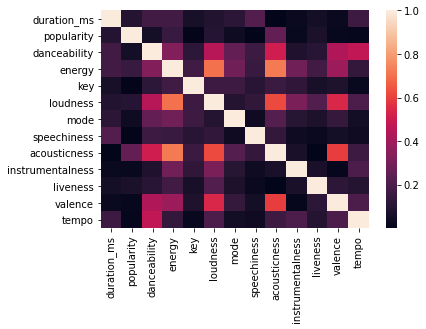

In [21]:
sns.heatmap(top_50_correlation_matrix.abs())